## Import libraries and user-defined functions

In [1]:
import gc
import mlflow
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from src.models.linear_models.pca_regressor import pca_regressor
from src.loaders.data_loader import load_energy_efficiency_dataset
from src.transformers.data_transformer import transform_energy_efficiency_dataset
from src.models.linear_models.elasticnet_pca_regressor import elasticnet_pca_regressor
from src.models.non_linear_models.decision_tree_regressor import decisiontree_regressor


## Import dataset

In [2]:
downloaded_features_df, downloaded_targets_df = load_energy_efficiency_dataset()
locally_loaded_features_df, locally_loaded_targets_df = pd.read_csv("../data/features.csv").map(float), pd.read_csv("../data/targets.csv").map(float)


In [ ]:
try:
    pd.testing.assert_frame_equal(downloaded_features_df, locally_loaded_features_df, check_exact=False)
    pd.testing.assert_frame_equal(downloaded_targets_df, locally_loaded_targets_df, check_exact=False)
    print("The datasets are identical.")
    features_df, targets_df = downloaded_features_df, downloaded_targets_df
except AssertionError:
    print("The datasets are different.")
    features_df, targets_df = locally_loaded_features_df, locally_loaded_targets_df

The datasets are identical.


In [4]:
features_df.sample(n=3, random_state=123)


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
236,0.62,808.5,367.5,220.5,3.5,2.0,0.10,4.0
395,0.86,588.0,294.0,147.0,7.0,5.0,0.25,3.0
36,0.66,759.5,318.5,220.5,3.5,2.0,0.00,0.0


In [5]:
targets_df.sample(n=3, random_state=123)


,Heating_Load,Cooling_Load
236,12.85,14.37
395,29.07,29.82
36,7.18,12.40


In [6]:
del downloaded_features_df, downloaded_targets_df, locally_loaded_features_df, locally_loaded_targets_df
gc.collect()


57

## Feature engineering

In [7]:
data = transform_energy_efficiency_dataset(
    features_df=features_df,
    targets_df=targets_df,
)
gc.collect()


12

## Data analysis

### _Original features_

In [8]:
data["train"]["features"]["original"].describe().T


,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,537.0,-3.208689e-16,1.000932,-1.375986,-0.725215,-0.074443,0.855231,1.970839
Surface_Area,537.0,2.613262e-16,1.000932,-1.722101,-0.901544,-0.080986,0.739571,1.560129
Wall_Area,537.0,-3.175610e-16,1.000932,-1.696886,-0.585633,-0.030006,0.525621,2.192501
Roof_Area,537.0,-2.249390e-16,1.000932,-1.419389,-1.148621,-0.607085,1.017523,1.017523
Overall_Height,537.0,1.157774e-17,1.000932,-1.047691,-1.047691,0.954480,0.954480,0.954480
Orientation,537.0,-1.653964e-17,1.000932,-1.312990,-1.312990,-0.421618,0.469755,1.361128
Glazing_Area,537.0,-6.285061e-17,1.000932,-1.793350,-1.035954,0.100140,1.236234,1.236234
Glazing_Area_Distribution,537.0,-1.058537e-16,1.000932,-1.796156,-1.159499,0.113816,0.750473,1.387131


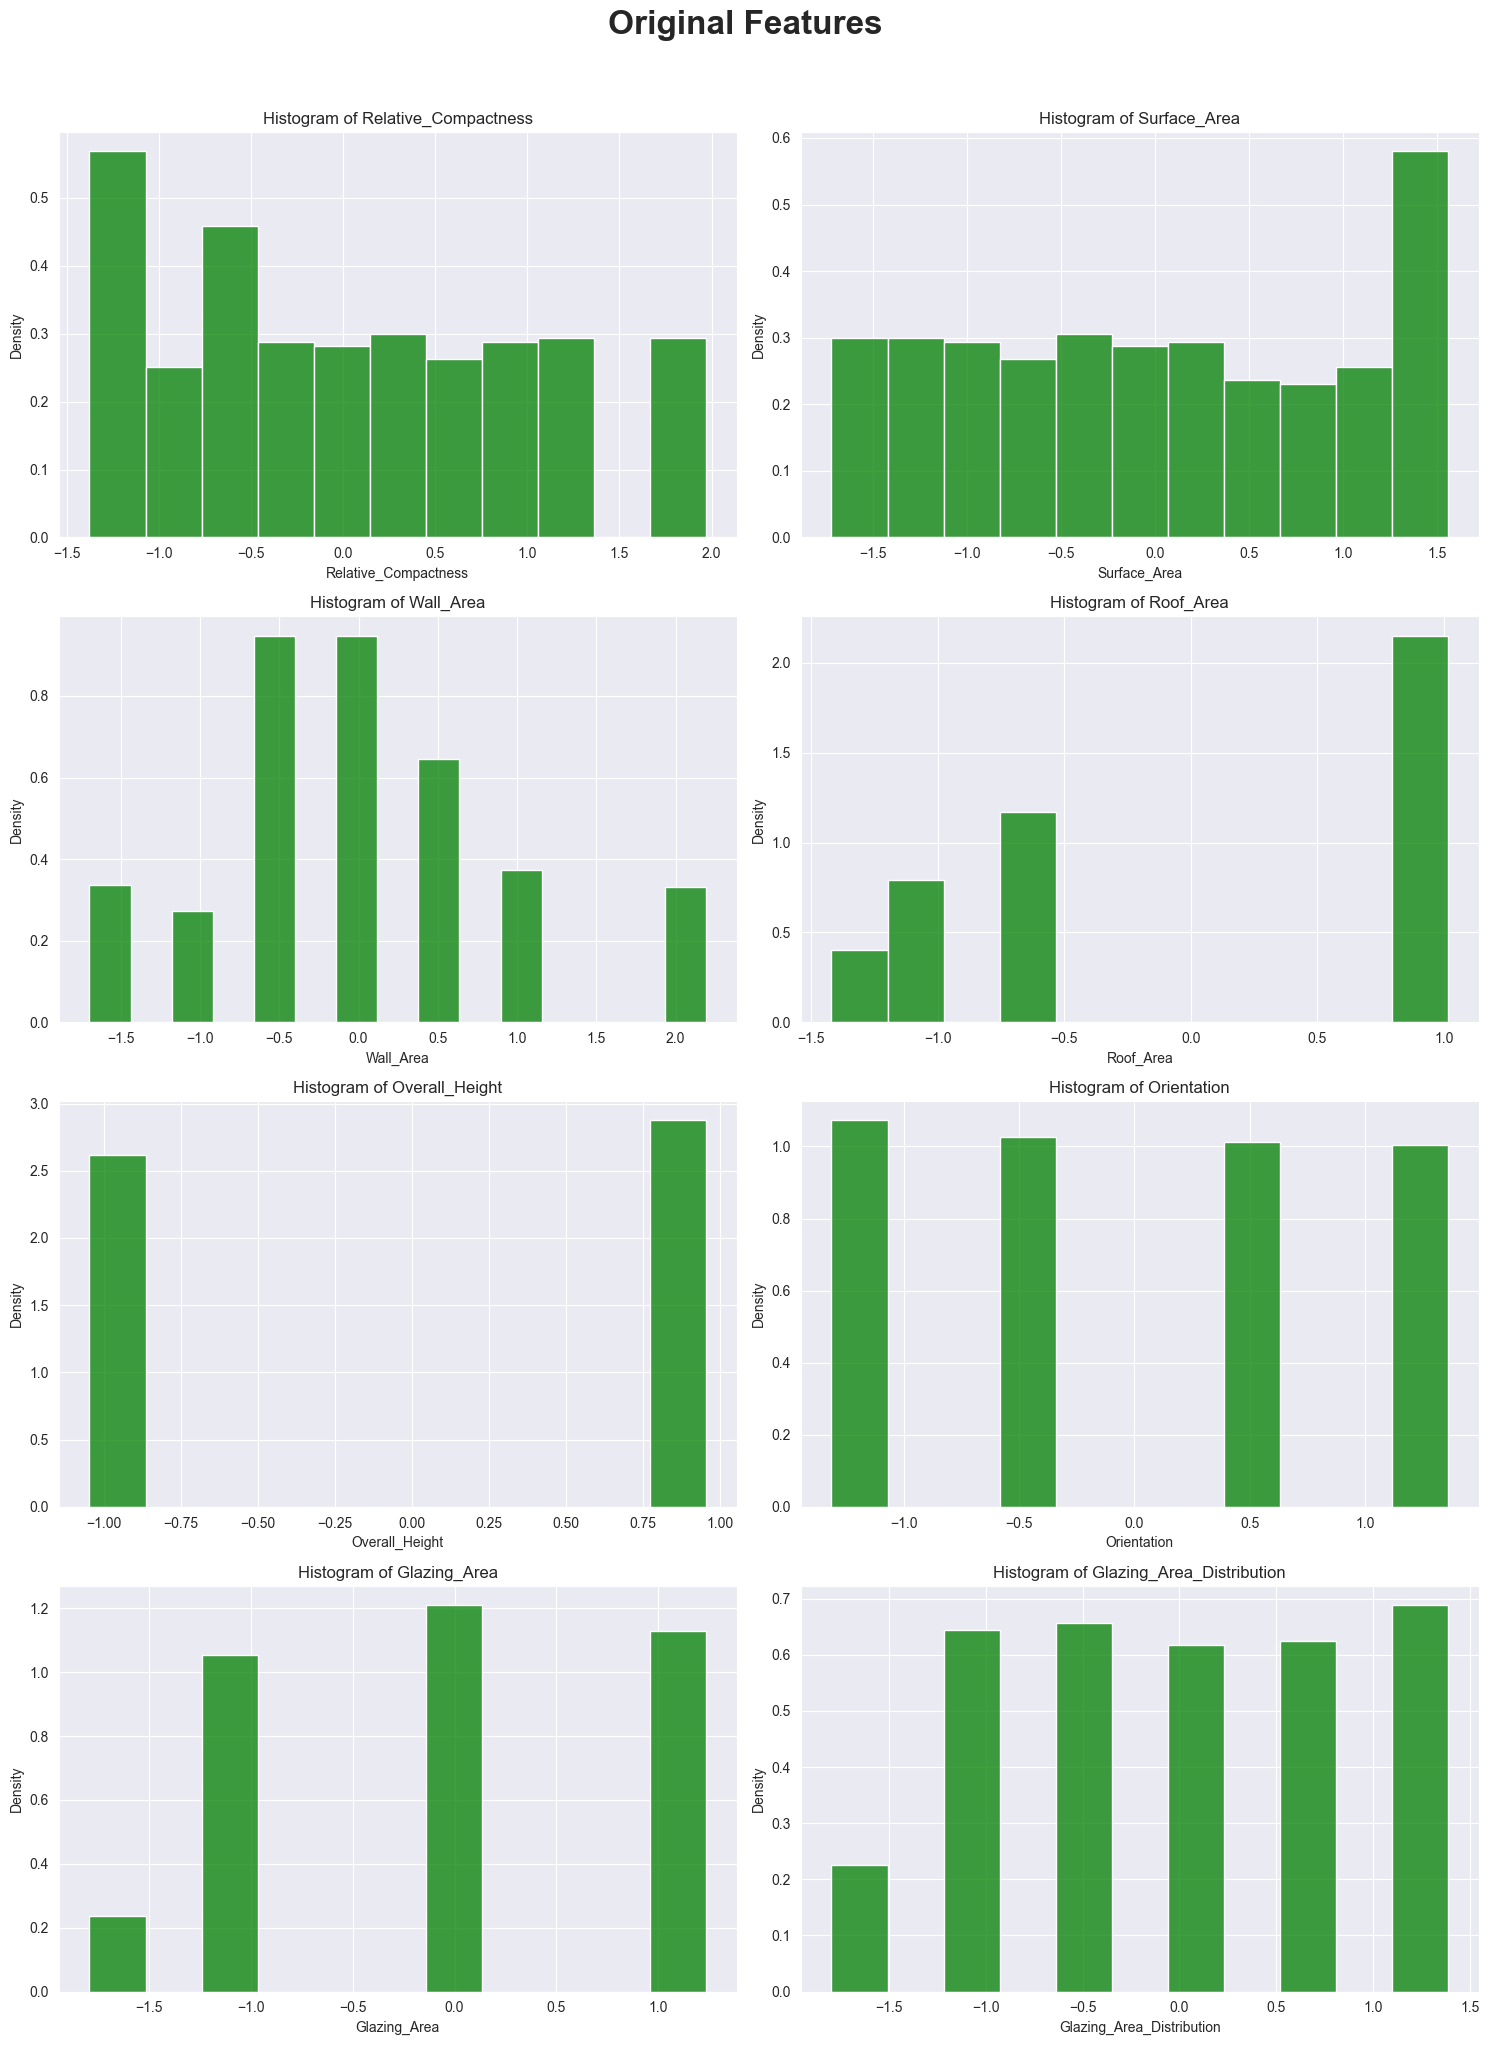

In [9]:
n_features = len(data["train"]["features"]["original"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows),
)
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Original Features",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

for x, feature in enumerate(data["train"]["features"]["original"].columns):
    row = x // 2
    col = x % 2

    sns.histplot(
        data=data["train"]["features"]["original"],
        x=feature,
        stat="density",
        color="green",
        ax=axes[row, col],
    )
    axes[row, col].set_title(f"Histogram of {feature}")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Density")

if n_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [10]:
for feature in data["train"]["features"]["original"].columns:
    print(f"Feature: {feature}, Number of unique values: {data["train"]["features"]["original"][feature].nunique()}")


Feature: Relative_Compactness, Number of unique values: 12
Feature: Surface_Area, Number of unique values: 12
Feature: Wall_Area, Number of unique values: 7
Feature: Roof_Area, Number of unique values: 4
Feature: Overall_Height, Number of unique values: 2
Feature: Orientation, Number of unique values: 4
Feature: Glazing_Area, Number of unique values: 4
Feature: Glazing_Area_Distribution, Number of unique values: 6


- Except Relative_Compactness and Surface_Area, other features seem to have very few unique values.
- Converting these features into categorical variables might be more beneficial.

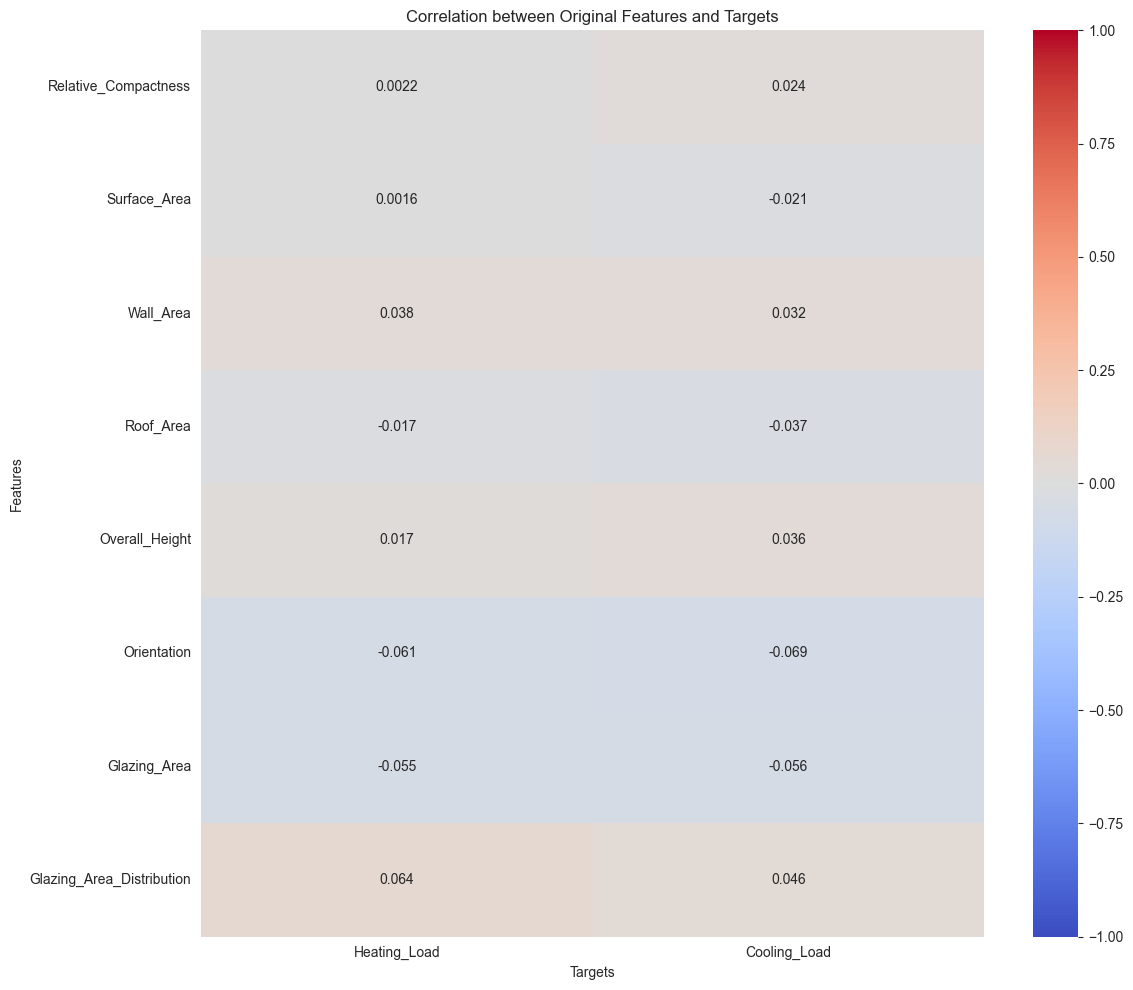

In [11]:
correlation_matrix = pd.DataFrame(index=data["train"]["features"]["original"].columns, columns=data["train"]["targets"].columns)
for feature in data["train"]["features"]["original"].columns:
    for target in data["train"]["targets"].columns:
        correlation_matrix.loc[feature, target] = data["train"]["features"]["original"][feature].corr(data["train"]["targets"][target])
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation between Original Features and Targets")
plt.xlabel("Targets")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


- Linear correlation coefficients found between features and targets vary from -6.9% to 6.4%.
- It suggests the linear relationship between these original features and targets is not apparently strong.

In [12]:
data["train"]["features"]["original"].corr()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
Relative_Compactness,1.000000,-0.991721,-0.233672,-0.867873,0.824266,-0.017961,0.034663,-0.002990
Surface_Area,-0.991721,1.000000,0.225390,0.880104,-0.855817,0.018521,-0.032975,0.000786
Wall_Area,-0.233672,0.225390,1.000000,-0.264197,0.254447,0.030697,-0.035003,-0.003172
Roof_Area,-0.867873,0.880104,-0.264197,1.000000,-0.971205,0.003375,-0.015586,0.002324
Overall_Height,0.824266,-0.855817,0.254447,-0.971205,1.000000,0.000291,0.011727,-0.001817
Orientation,-0.017961,0.018521,0.030697,0.003375,0.000291,1.000000,0.003876,-0.005910
Glazing_Area,0.034663,-0.032975,-0.035003,-0.015586,0.011727,0.003876,1.000000,0.259336
Glazing_Area_Distribution,-0.002990,0.000786,-0.003172,0.002324,-0.001817,-0.005910,0.259336,1.000000



- There seems so to be some high linear correlation between features such as Relative_Compactness, Surface_Area, Roof_Area, and Overall_Height.
- Before using these features as inputs for a linear regression model, transforming them by doing a Principal Component Analysis (PCA) will be very beneficial.


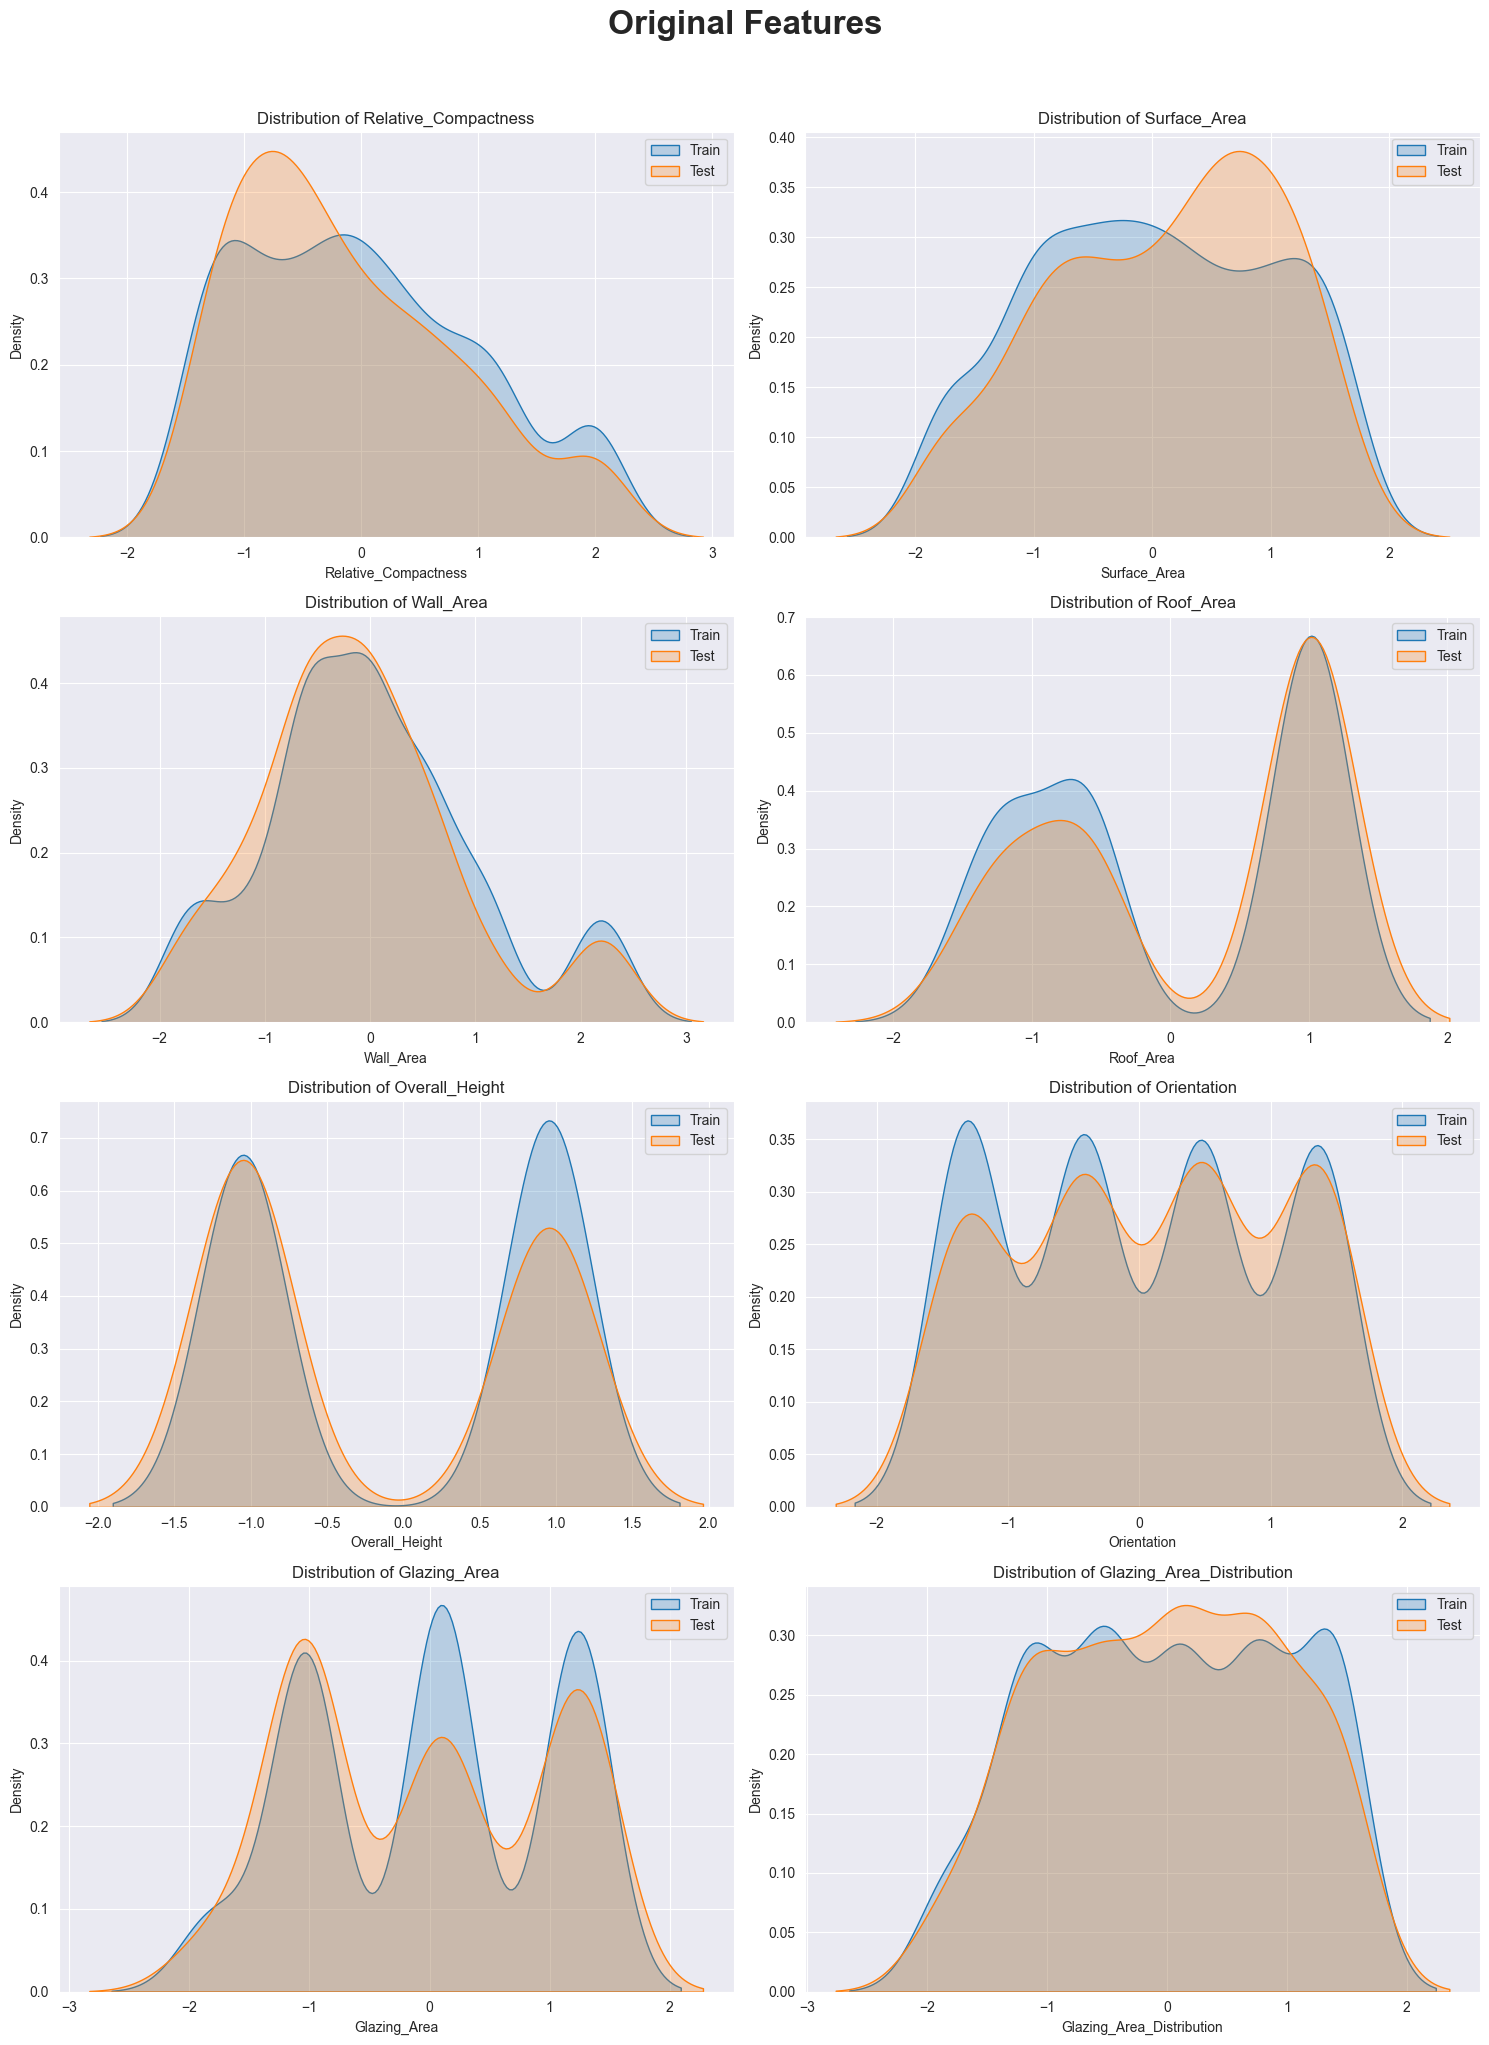

In [13]:
n_features = len(data["train"]["features"]["original"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Original Features",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

for x, feature in enumerate(data["train"]["features"]["original"].columns):
    row = x // 2
    col = x % 2

    ax = axes[row, col] if n_rows > 1 else axes[col]

    sns.kdeplot(
        data=data["train"]["features"]["original"][feature],
        label="Train",
        fill=True,
        ax=ax,
    )
    sns.kdeplot(
        data=data["test"]["features"]["original"][feature],
        label="Test",
        fill=True,
        ax=ax,
    )

    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

if n_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [14]:
for feature in data["train"]["features"]["original"].columns:
    print("--------------------------------------------------")
    statistic, p_value = stats.ks_2samp(data["train"]["features"]["original"][feature], data["test"]["features"]["original"][feature])
    print(f"Feature: {feature}, Kolmogorov-Smirnov statistic: {statistic:.3f}, p-value: {p_value:.3f}")
    print("--------------------------------------------------")


--------------------------------------------------
Feature: Relative_Compactness, Kolmogorov-Smirnov statistic: 0.091, p-value: 0.125
--------------------------------------------------
--------------------------------------------------
Feature: Surface_Area, Kolmogorov-Smirnov statistic: 0.091, p-value: 0.125
--------------------------------------------------
--------------------------------------------------
Feature: Wall_Area, Kolmogorov-Smirnov statistic: 0.056, p-value: 0.671
--------------------------------------------------
--------------------------------------------------
Feature: Roof_Area, Kolmogorov-Smirnov statistic: 0.077, p-value: 0.271
--------------------------------------------------
--------------------------------------------------
Feature: Overall_Height, Kolmogorov-Smirnov statistic: 0.077, p-value: 0.271
--------------------------------------------------
--------------------------------------------------
Feature: Orientation, Kolmogorov-Smirnov statistic: 0.036, p

According to the Kolmogorov-Smirnov test of a 95% confidence level, there is no significant difference between the distributions of the original features in the training and test sets.

In [15]:
del correlation_matrix
gc.collect()

5951

### _Noisy features_

Some gaussian noises were added to original features in the training set to create noisy ones. You can refer to <code>src/transformers/data_transformer.py</code> for all details on their creation.

In [16]:
data["train"]["features"]["noise"].describe().T


,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,537.0,-8.269818e-17,1.000932,-2.847157,-0.699746,-0.047678,0.652248,3.324457
Surface_Area,537.0,8.600610e-16,1.000932,-1.735303,-0.896794,-0.077472,0.748309,1.572917
Wall_Area,537.0,1.653964e-16,1.000932,-1.725351,-0.589413,-0.031232,0.527496,2.217355
Roof_Area,537.0,-3.026753e-16,1.000932,-1.444038,-1.134411,-0.593613,1.016447,1.045861
Overall_Height,537.0,1.223933e-16,1.000932,-1.762849,-1.000117,0.471136,0.947181,1.654638
Orientation,537.0,3.969512e-16,1.000932,-2.148336,-0.846794,0.016944,0.819505,2.166695
Glazing_Area,537.0,3.307927e-18,1.000932,-3.574157,-0.662404,0.076782,0.705888,2.689023
Glazing_Area_Distribution,537.0,6.615854e-18,1.000932,-2.196026,-0.837834,0.017236,0.835181,1.952333


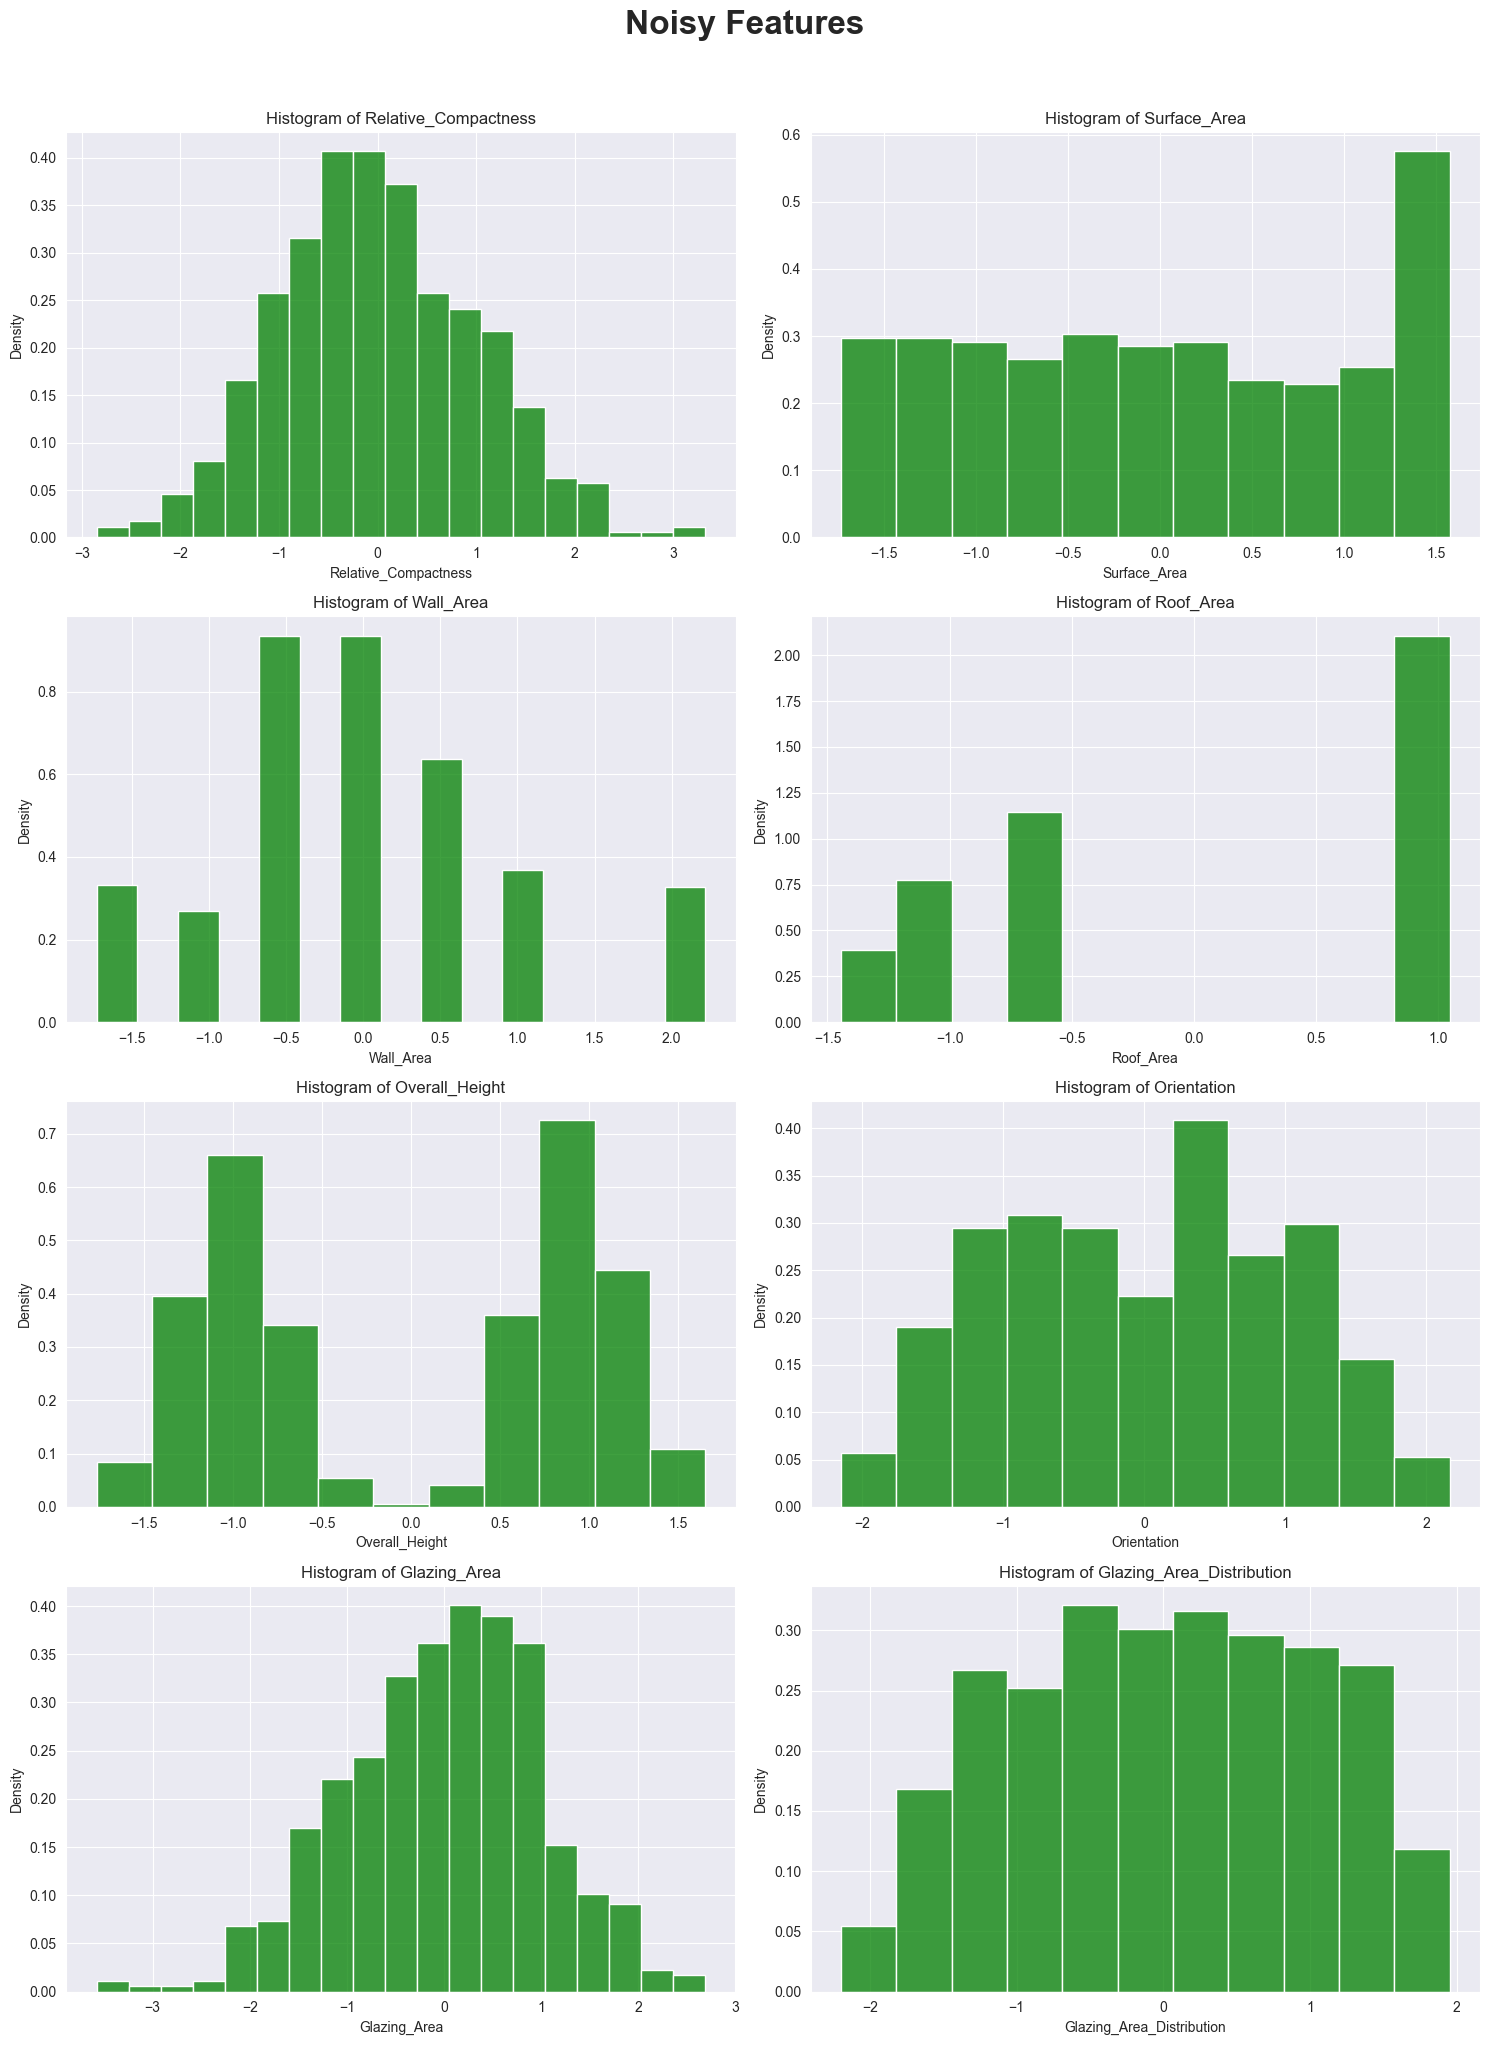

In [17]:
n_features = len(data["train"]["features"]["noise"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Noisy Features",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

for x, feature in enumerate(data["train"]["features"]["noise"].columns):
    row = x // 2
    col = x % 2

    sns.histplot(
        data=data["train"]["features"]["noise"],
        x=feature,
        stat="density",
        color="green",
        ax=axes[row, col],
    )
    axes[row, col].set_title(f"Histogram of {feature}")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Density")

if n_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [18]:
for feature in data["train"]["features"]["noise"].columns:
    print(f"Feature: {feature}, Number of unique values: {data["train"]["features"]["noise"][feature].nunique()}")


Feature: Relative_Compactness, Number of unique values: 537
Feature: Surface_Area, Number of unique values: 537
Feature: Wall_Area, Number of unique values: 537
Feature: Roof_Area, Number of unique values: 537
Feature: Overall_Height, Number of unique values: 537
Feature: Orientation, Number of unique values: 537
Feature: Glazing_Area, Number of unique values: 537
Feature: Glazing_Area_Distribution, Number of unique values: 537


- The introduction of a gaussian noise has made original features having more unique values.
- They appear to be more continuous compared to their original version.

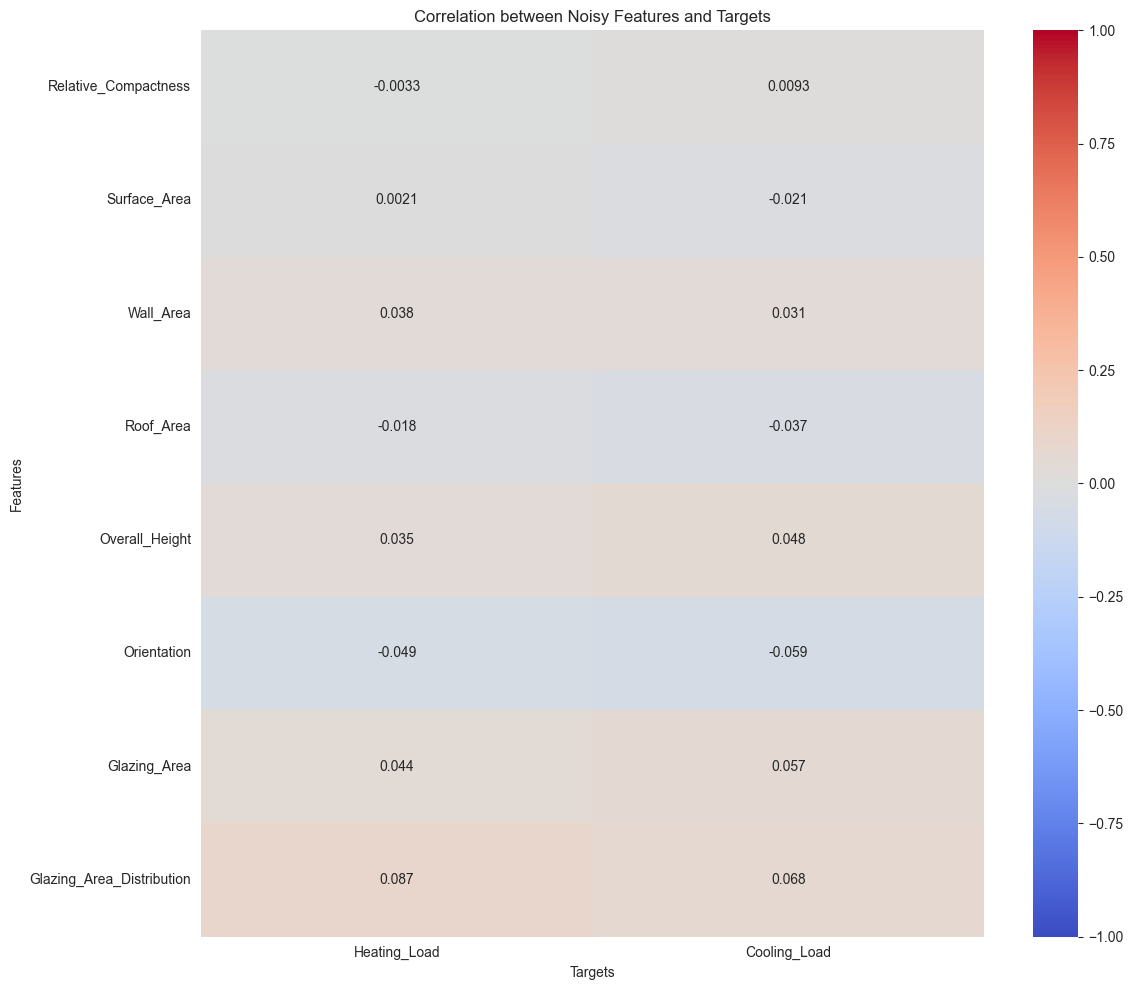

In [19]:
correlation_matrix = pd.DataFrame(index=data["train"]["features"]["noise"].columns, columns=data["train"]["targets"].columns)
for feature in data["train"]["features"]["noise"].columns:
    for target in data["train"]["targets"].columns:
        correlation_matrix.loc[feature, target] = data["train"]["features"]["noise"][feature].corr(data["train"]["targets"][target])
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation between Noisy Features and Targets")
plt.xlabel("Targets")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


- Linear correlation coefficients found between features and targets vary from -5.9% to 8.7%.
- The linear relationship between these noisy features and targets is still not apparently so strong, but is better than what's provided by original features.

In [20]:
data["train"]["features"]["noise"].corr()


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
Relative_Compactness,1.000000,-0.197518,0.013027,-0.202611,0.182708,0.015054,-0.015448,-0.022158
Surface_Area,-0.197518,1.000000,0.226237,0.880091,-0.816116,0.041438,-0.022041,0.018716
Wall_Area,0.013027,0.226237,1.000000,-0.263200,0.250899,0.029665,-0.038311,0.008142
Roof_Area,-0.202611,0.880091,-0.263200,1.000000,-0.930405,0.026001,-0.002104,0.015288
Overall_Height,0.182708,-0.816116,0.250899,-0.930405,1.000000,-0.034665,0.022869,-0.037137
Orientation,0.015054,0.041438,0.029665,0.026001,-0.034665,1.000000,0.004271,-0.011002
Glazing_Area,-0.015448,-0.022041,-0.038311,-0.002104,0.022869,0.004271,1.000000,0.102436
Glazing_Area_Distribution,-0.022158,0.018716,0.008142,0.015288,-0.037137,-0.011002,0.102436,1.000000


- There seems so to be some high linear correlation between features such as Surface_Area, Roof_Area, and Overall_Height.
- Before using these features as inputs for a linear regression model, transforming them by doing a Principal Component Analysis (PCA) will be very beneficial.


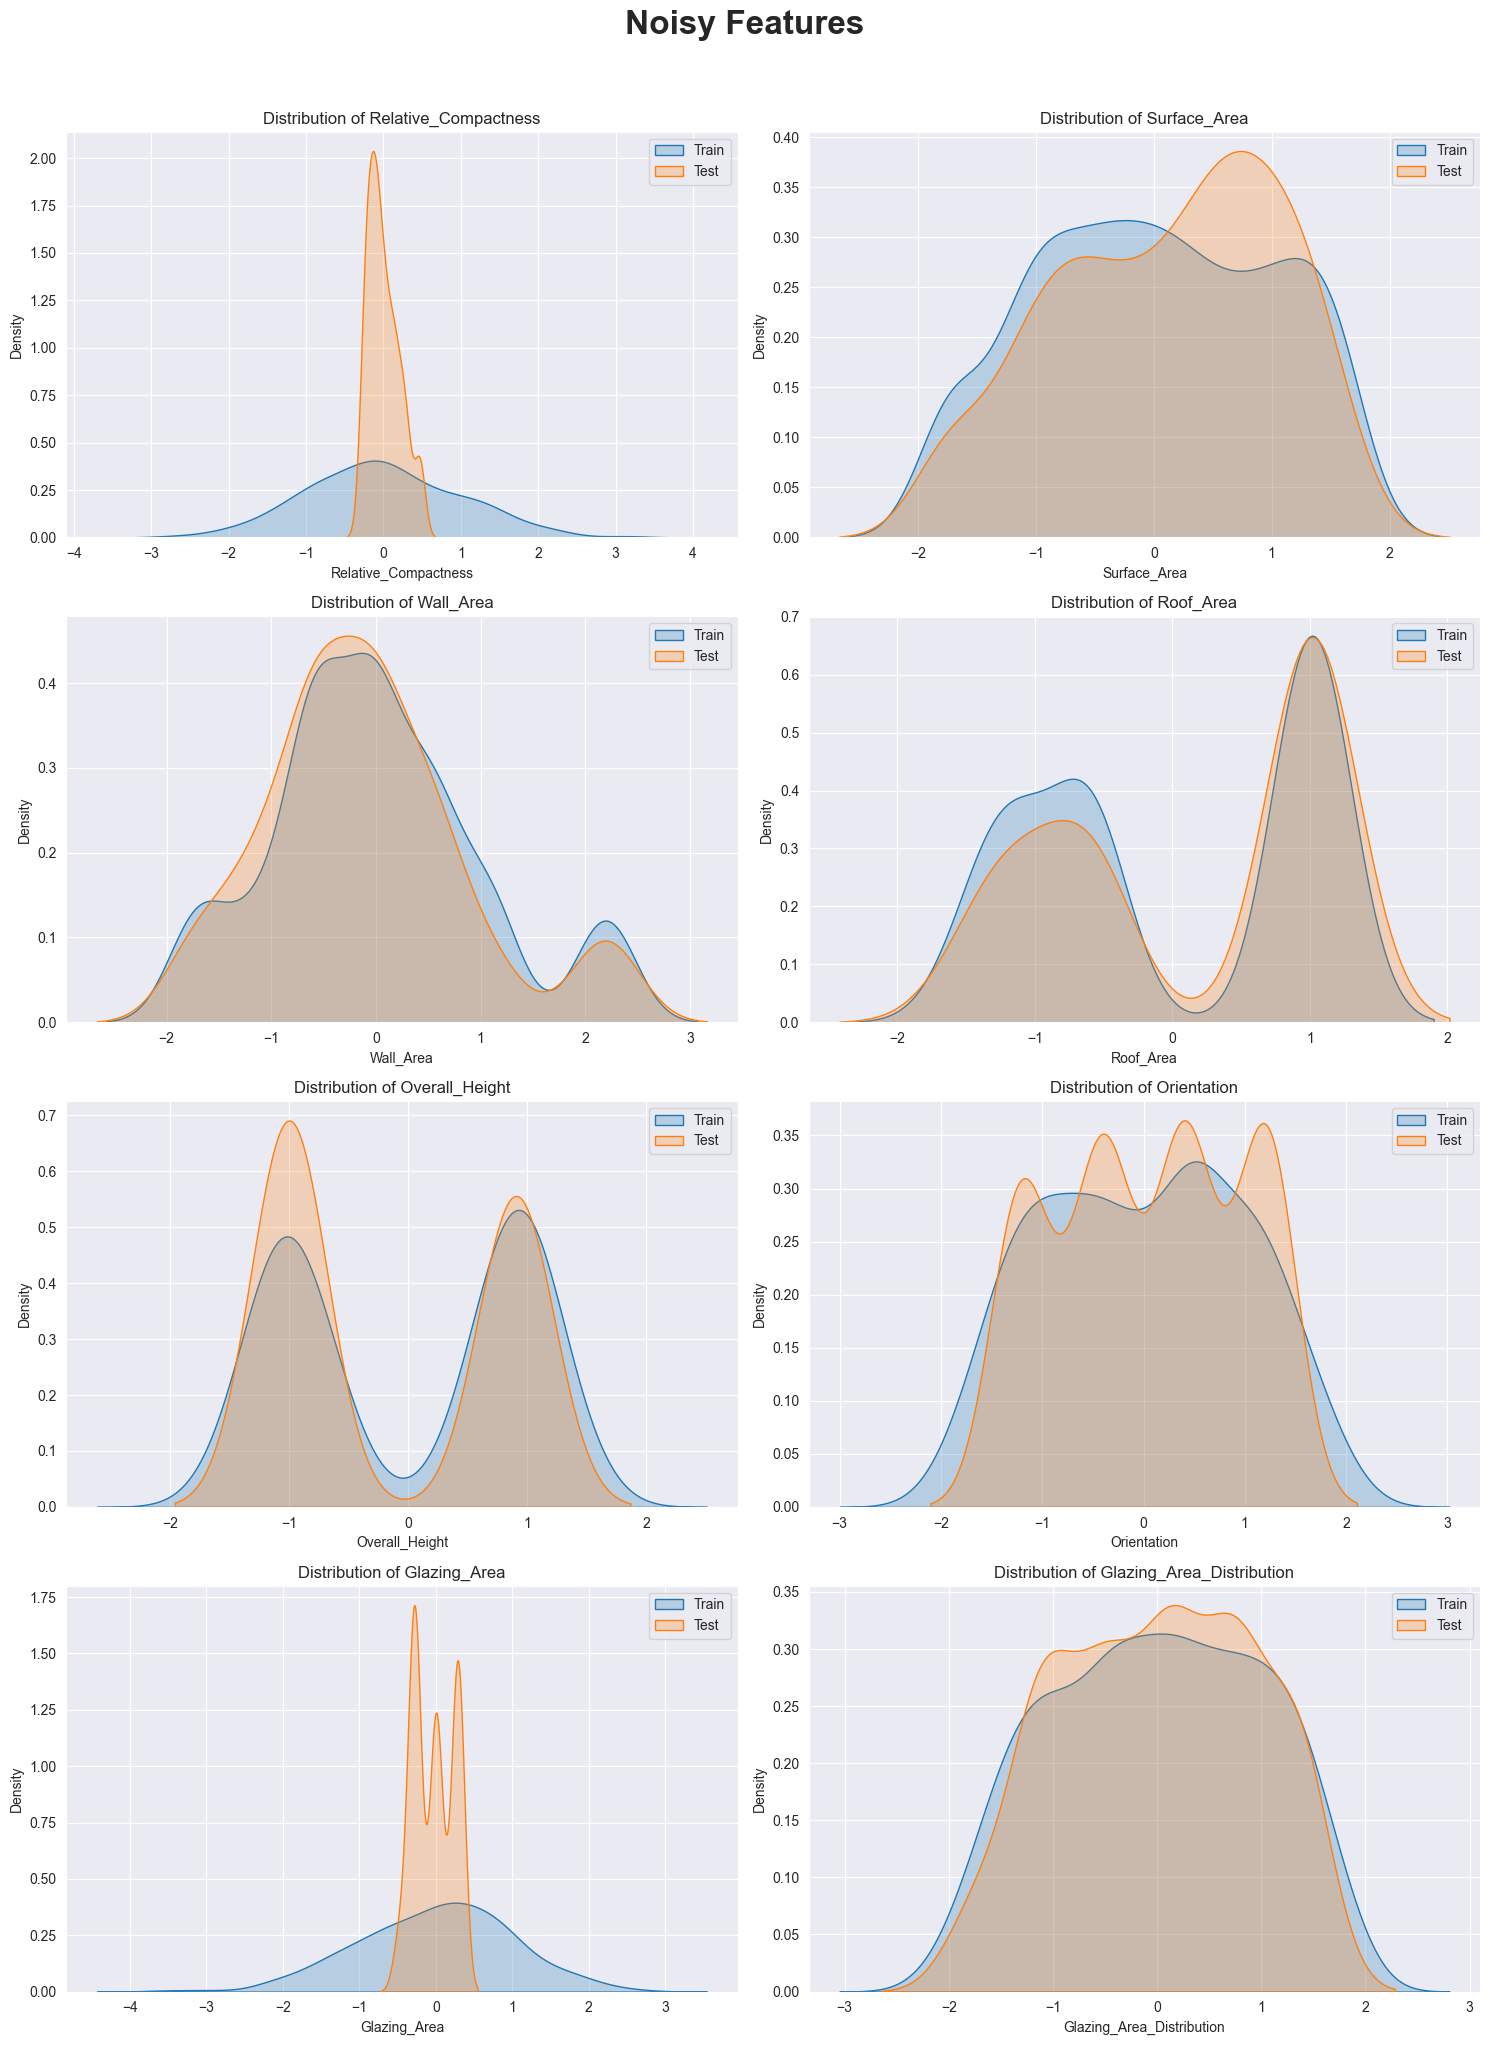

In [21]:
n_features = len(data["train"]["features"]["noise"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Noisy Features",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

for x, feature in enumerate(data["train"]["features"]["noise"].columns):
    row = x // 2
    col = x % 2

    ax = axes[row, col] if n_rows > 1 else axes[col]

    sns.kdeplot(
        data=data["train"]["features"]["noise"][feature],
        label="Train",
        fill=True,
        ax=ax,
    )
    sns.kdeplot(
        data=data["test"]["features"]["noise"][feature],
        label="Test",
        fill=True,
        ax=ax,
    )

    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

if n_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [22]:
for feature in data["train"]["features"]["noise"].columns:
    print("--------------------------------------------------")
    statistic, p_value = stats.ks_2samp(data["train"]["features"]["noise"][feature], data["test"]["features"]["noise"][feature])
    print(f"Feature: {feature}, Kolmogorov-Smirnov statistic: {statistic:.3f}, p-value: {p_value:.3f}")
    print("--------------------------------------------------")


--------------------------------------------------
Feature: Relative_Compactness, Kolmogorov-Smirnov statistic: 0.400, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Surface_Area, Kolmogorov-Smirnov statistic: 0.130, p-value: 0.007
--------------------------------------------------
--------------------------------------------------
Feature: Wall_Area, Kolmogorov-Smirnov statistic: 0.195, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Roof_Area, Kolmogorov-Smirnov statistic: 0.333, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Overall_Height, Kolmogorov-Smirnov statistic: 0.308, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Orientation, Kolmogorov-Smirnov statistic: 0.160, p

According to the Kolmogorov-Smirnov test of a 95% confidence level, there is significant difference between the distributions of the noisy features in the training and test sets.

In [23]:
del correlation_matrix
gc.collect()


53822

### _Targets_

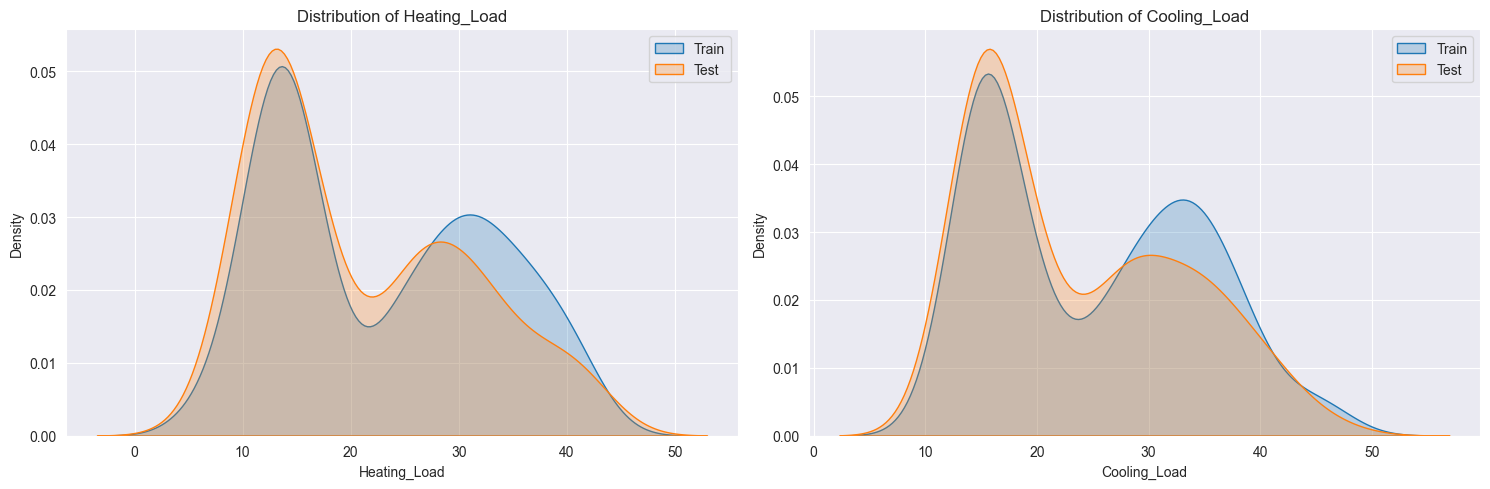

In [24]:
n_features = len(data["train"]["targets"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=3.0)

for x, target in enumerate(data["train"]["targets"].columns):
    row = x // 2
    col = x % 2

    ax = axes[row, col] if n_rows > 1 else axes[col]

    sns.kdeplot(
        data=data["train"]["targets"][target],
        label="Train",
        fill=True,
        ax=ax,
    )
    sns.kdeplot(
        data=data["test"]["targets"][target],
        label="Test",
        fill=True,
        ax=ax,
    )
    ax.set_title(f"Distribution of {target}")
    ax.set_xlabel(target)
    ax.set_ylabel("Density")
    ax.legend()

if n_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [25]:
for target in data["train"]["targets"].columns:
    print("--------------------------------------------------")
    statistic, p_value = stats.ks_2samp(
        data1=data["train"]["targets"][target],
        data2=data["test"]["targets"][target],
    )
    print(f"Target: {target}, Kolmogorov-Smirnov statistic: {statistic:.3f}, p-value: {p_value:.3f}")
    print("--------------------------------------------------")


--------------------------------------------------
Target: Heating_Load, Kolmogorov-Smirnov statistic: 0.115, p-value: 0.026
--------------------------------------------------
--------------------------------------------------
Target: Cooling_Load, Kolmogorov-Smirnov statistic: 0.105, p-value: 0.053
--------------------------------------------------


- The distribution shape of both targets is quite different from a normal distribution.
- According to the Kolmogorov-Smirnov test of a 95% confidence level, the target Heating_Load seems to present differences between its data distribution in the training and test sets.

## Launch MLflow server to record some experiments

We will run some MLflow experiments locally. Before going any further from the section `pca + elasticnet`, don't forget to start your local server with commands such as :

`mlflow server --host localhost --port 9999`.

You can change the server uri and port according to your setup.

In [26]:
mlflow.set_tracking_uri("http://localhost:9999")

## Linear models

### pca

In [27]:
training_pca_results = {
    "original": pca_regressor(
        features_df=data["train"]["features"]["original"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
    ),
    "noise": pca_regressor(
        features_df=data["train"]["features"]["noise"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
    ),
}


In [28]:
test_pca_results = {
    "original": pca_regressor(
        features_df=data["test"]["features"]["original"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        prediction_models=training_pca_results["original"],
    ),
    "noise": pca_regressor(
        features_df=data["test"]["features"]["noise"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        prediction_models=training_pca_results["noise"],
    ),
}


In [29]:
pca_perfs = []

for target_name in data["train"]["targets"].columns:
    for version in ["original", "noise"]:
        pca_perfs.append(
            {
                "Target": target_name,
                "Features version": version,
                "Train MSE": f"{training_pca_results[version][target_name]['train_mse_score']:.3f}",
                "Train R2": f"{training_pca_results[version][target_name]['train_r2_score']:.3f}",
                "Validation MSE": f"{training_pca_results[version][target_name]['val_mse_score']:.3f}",
                "Validation R2": f"{training_pca_results[version][target_name]['val_r2_score']:.3f}",
                "Test MSE": f"{test_pca_results[version][target_name]['mse_score']:.3f}",
                "Test R2": f"{test_pca_results[version][target_name]['r2_score']:.3f}"
            }
        )

pca_perfs_df = pd.DataFrame(pca_perfs)
pca_perfs_df


,Target,Features version,Train MSE,Train R2,Validation MSE,Validation R2,Test MSE,Test R2
0,Heating_Load,original,15.360,0.851,15.861,0.845,45.219,0.526
1,Heating_Load,noise,19.503,0.811,20.034,0.805,22.469,0.764
2,Cooling_Load,original,16.915,0.816,17.385,0.809,35.118,0.589
3,Cooling_Load,noise,18.838,0.795,19.356,0.788,19.272,0.774


- Linear models using PCA components have shown high R-squared values (at least 0.7) during the training  and validation for both targets and any version of the features.
- Comparing training and validation results have shown that no model has been severely overfitted.
- Noisy versions of the features had the best generalization performance for both metrics (mse, r2) for all targets.

In [30]:
gc.collect()


56404

### pca + elasticnet

In [31]:
training_pca_elasticnet_results = {
    "original": elasticnet_pca_regressor(
        features_df=data["train"]["features"]["original"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/regularized_linear_pca_regression_for_energy_efficiency_prediction-original-{datetime.now().strftime('%Y-%m-%d')}"
    ),
    "noise": elasticnet_pca_regressor(
        features_df=data["train"]["features"]["noise"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/regularized_linear_pca_regression_for_energy_efficiency_prediction-noise-{datetime.now().strftime('%Y-%m-%d')}"
    ),
}


Experiment /regularized_linear_pca_regression_for_energy_efficiency_prediction-original-2024-12-25 is deleted. Restoring it...
Experiment /regularized_linear_pca_regression_for_energy_efficiency_prediction-original-2024-12-25 successfully restored.
🏃 View run stylish-hare-407 at: http://localhost:9999/#/experiments/184874826734901386/runs/aea8fdfb23444c17b85e76fd22e2e714

🧪 View experiment at: http://localhost:9999/#/experiments/184874826734901386

🏃 View run enthused-deer-724 at: http://localhost:9999/#/experiments/184874826734901386/runs/c7d07dafd731490eae4dea317cc5b42b

🧪 View experiment at: http://localhost:9999/#/experiments/184874826734901386 

🏃 View run polite-wolf-873 at: http://localhost:9999/#/experiments/184874826734901386/runs/7f08557a3db34309b4f6d569af7e2ae5

🧪 View experiment at: http://localhost:9999/#/experiments/184874826734901386 

🏃 View run unruly-fish-721 at: http://localhost:9999/#/experiments/184874826734901386/runs/e15a78b0e432482d8ad4b53d471424d9

🧪 View exper

In [32]:
test_pca_elasticnet_results = {
    "original": elasticnet_pca_regressor(
        features_df=data["test"]["features"]["original"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_pca_elasticnet_results["original"],
    ),
    "noise": elasticnet_pca_regressor(
        features_df=data["test"]["features"]["noise"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_pca_elasticnet_results["noise"],
    ),
}


In [33]:
elasticnet_pca_perfs = []

for version in ["original", "noise"]:
    elasticnet_pca_perfs.append(
        {
            "Features version": version,
            "Train MSE": f"{training_pca_elasticnet_results[version]['train_mse_score']:.3f}",
            "Train R2": f"{training_pca_elasticnet_results[version]['train_r2_score']:.3f}",
            "Validation MSE": f"{training_pca_elasticnet_results[version]['val_mse_score']:.3f}",
            "Validation R2": f"{training_pca_elasticnet_results[version]['val_r2_score']:.3f}",
            "Test MSE": f"{test_pca_elasticnet_results[version]['mse_score']:.3f}",
            "Test R2": f"{test_pca_elasticnet_results[version]['r2_score']:.3f}",
        }
    )

elasticnet_pca_perfs_df = pd.DataFrame(elasticnet_pca_perfs)
elasticnet_pca_perfs_df


,Features version,Train MSE,Train R2,Validation MSE,Validation R2,Test MSE,Test R2
0,original,16.917,0.816,17.884,0.809,44.964,0.528
1,noise,19.588,0.795,21.057,0.786,22.399,0.765


- Regularized linear models using PCA components have shown high R-squared values (at least 0.7) during the training and validation for both targets and any version of the features.
- Comparing training and validation results have shown that no model has been severely overfitted.
- Noisy versions of the features had the best generalization performance for both metrics (mse, r2) for all targets.

In [34]:
gc.collect()


852

## Non Linear models

### decision tree

In [35]:
training_decisiontree_results = {
    "original": decisiontree_regressor(
        features_df=data["train"]["features"]["original"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/decision_tree_for_energy_efficiency_prediction-original-{datetime.now().strftime('%Y-%m-%d')}"
    ),
    "noise": decisiontree_regressor(
        features_df=data["train"]["features"]["noise"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/decision_tree__for_energy_efficiency_prediction-noise-{datetime.now().strftime('%Y-%m-%d')}"
    ),
}

Experiment /decision_tree_for_energy_efficiency_prediction-original-2024-12-25 is deleted. Restoring it...
Experiment /decision_tree_for_energy_efficiency_prediction-original-2024-12-25 successfully restored.
🏃 View run big-cod-565 at: http://localhost:9999/#/experiments/177113473246961404/runs/acd87b956ce24ec4b50e09f4ec28eddf

🧪 View experiment at: http://localhost:9999/#/experiments/177113473246961404

🏃 View run luminous-bird-469 at: http://localhost:9999/#/experiments/177113473246961404/runs/a9261961d758461aac590a627b599365

🧪 View experiment at: http://localhost:9999/#/experiments/177113473246961404  

🏃 View run suave-turtle-407 at: http://localhost:9999/#/experiments/177113473246961404/runs/53c096ad23e04a25843c1ffa66dbd790

🧪 View experiment at: http://localhost:9999/#/experiments/177113473246961404  

🏃 View run industrious-yak-669 at: http://localhost:9999/#/experiments/177113473246961404/runs/c9dec368a1e3441daf1539f8c879e1f1

🧪 View experiment at: http://localhost:9999/#/expe

In [36]:
test_decisiontree_results = {
    "original": decisiontree_regressor(
        features_df=data["test"]["features"]["original"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_decisiontree_results["original"],
    ),
    "noise": decisiontree_regressor(
        features_df=data["test"]["features"]["noise"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_decisiontree_results["noise"],
    ),
}


In [37]:
decisiontree_perfs = []

for version in ["original", "noise"]:
    decisiontree_perfs.append(
        {
            "Features version": version,
            "Train MSE": f"{training_decisiontree_results[version]['train_mse_score']:.3f}",
            "Train R2": f"{training_decisiontree_results[version]['train_r2_score']:.3f}",
            "Validation MSE": f"{training_decisiontree_results[version]['val_mse_score']:.3f}",
            "Validation R2": f"{training_decisiontree_results[version]['val_r2_score']:.3f}",
            "Test MSE": f"{test_decisiontree_results[version]['mse_score']:.3f}",
            "Test R2": f"{test_decisiontree_results[version]['r2_score']:.3f}",
        }
    )

decisiontree_perfs_df = pd.DataFrame(decisiontree_perfs)
decisiontree_perfs_df


,Features version,Train MSE,Train R2,Validation MSE,Validation R2,Test MSE,Test R2
0,original,2.761,0.970,3.886,0.958,3.171,0.963
1,noise,8.512,0.918,10.110,0.900,9.043,0.905


- Decision trees performance is significantly higher than linear models' one.
- Noisy features seem to be a good option in the linear case, but with decision trees, the noise seems to have a negative impact.

In [38]:
training_decisiontree_results["original"]["features_importance"]

,feature,importance
0,Relative_Compactness,0.009339
1,Surface_Area,0.087980
2,Wall_Area,0.014661
3,Roof_Area,0.000770
4,Overall_Height,0.808263
5,Orientation,0.000518
6,Glazing_Area,0.074460
7,Glazing_Area_Distribution,0.004009


- The feature Overall_Height appears to be the most important feature in predicting targets.
- His importance score is at least 10 times greater than this of any other feature.
- The decision tree will be the final model kept for the energy efficiency prediction task.

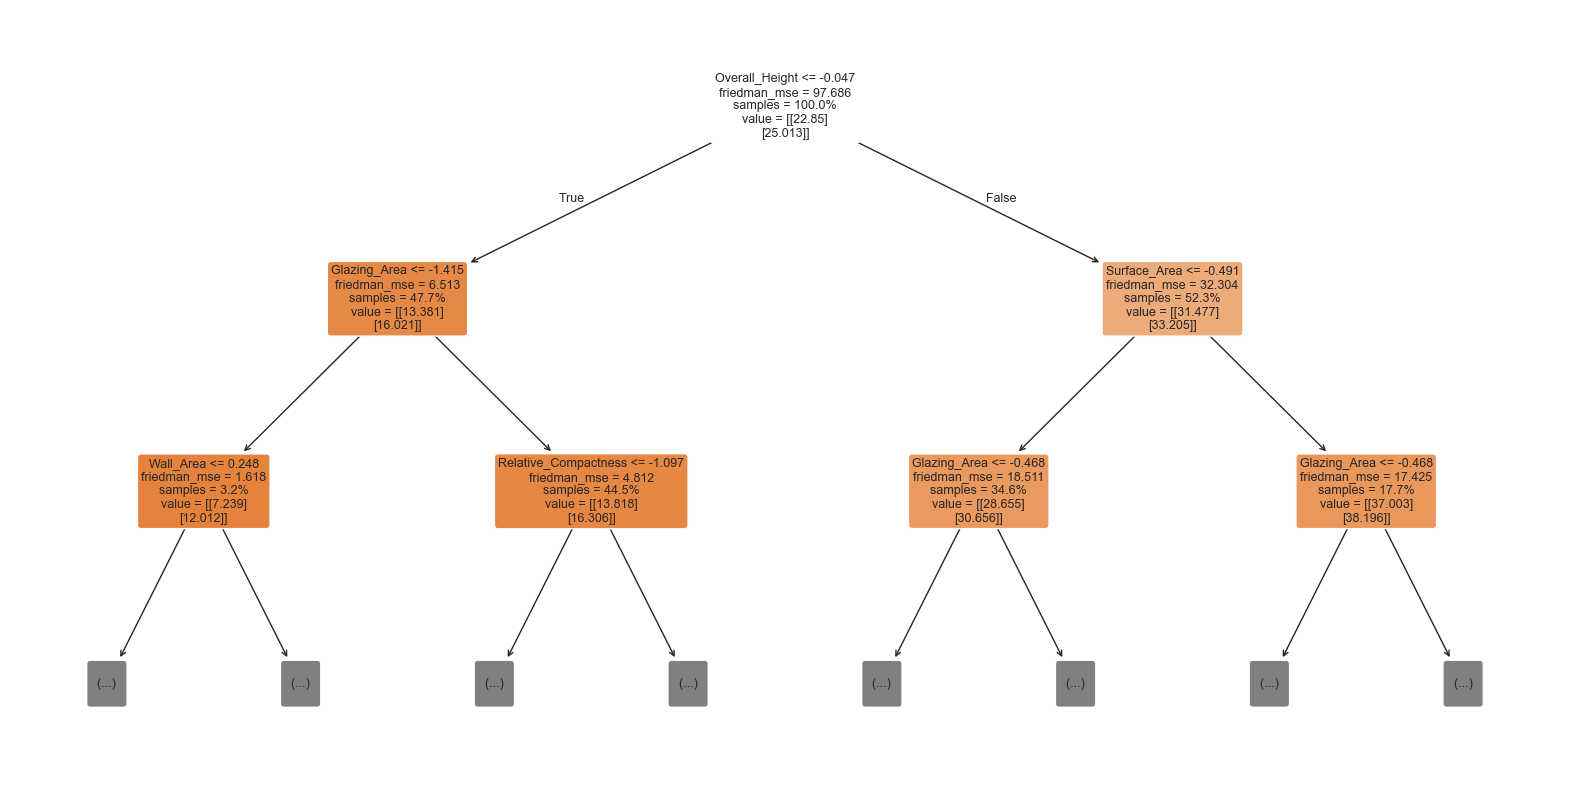

In [39]:
final_predictor = training_decisiontree_results["original"]["model"]

plt.figure(figsize=(20, 10))
plot_tree(
    final_predictor,
    feature_names=data["train"]["features"]["original"].columns,
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=2, # Set up the max depth for better visualization
)
plt.show()

# Predictions vs Actual values on test set

In [40]:
actual_values_df = data["test"]["targets"]
predicted_values_df = pd.DataFrame(
    data=final_predictor.predict(data["test"]["features"]["original"]),
    columns=final_predictor.y_train.columns,
)


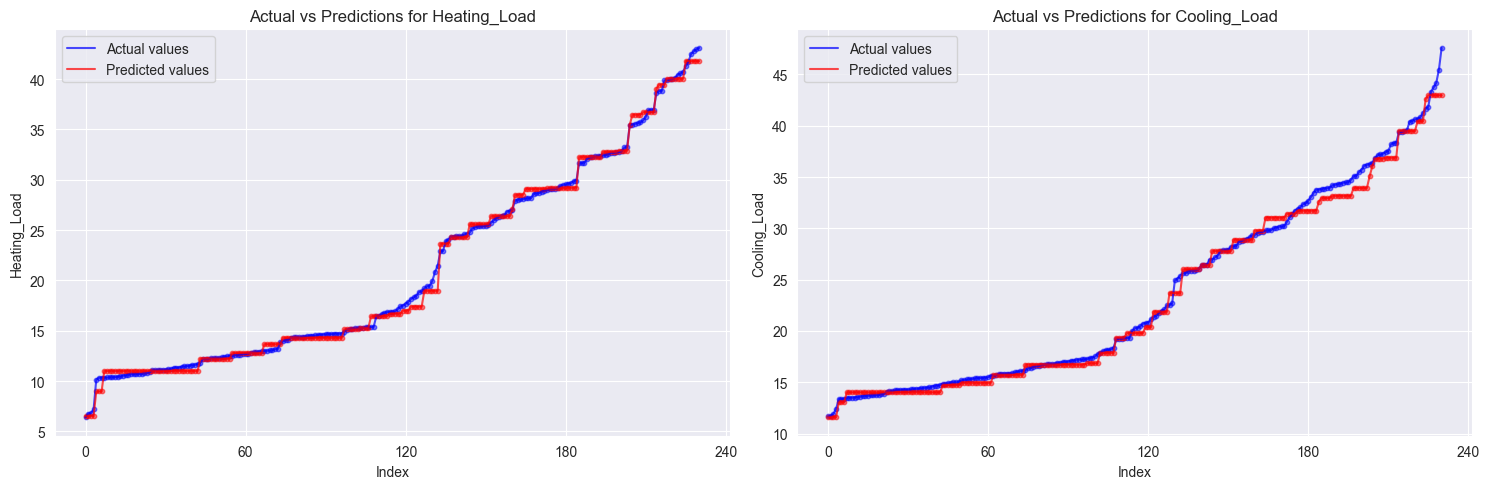

In [41]:
n_targets = len(final_predictor.y_train.columns)
n_rows = (n_targets + 1) // 2
n_cols = 2 if n_targets > 1 else 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
fig.tight_layout(pad=3.0)

for x, target in enumerate(final_predictor.y_train.columns):
    row = x // 2
    col = x % 2

    ax = axes[row, col]

    actual_df = actual_values_df[target].sort_values().reset_index(drop=True)
    ax.plot(actual_df.index, actual_df.values, "b-", label="Actual values", alpha=0.7)
    ax.scatter(actual_df.index, actual_df.values, color="blue", s=10, alpha=0.5)

    predicted_df = predicted_values_df[target].sort_values().reset_index(drop=True)
    ax.plot(predicted_df.index, predicted_df.values, "r-", label="Predicted values", alpha=0.7)
    ax.scatter(predicted_df.index, predicted_df.values, color="red", s=10, alpha=0.5)

    ax.set_title(f"Actual vs Predictions for {target}")
    ax.set_xlabel("Index")
    ax.set_ylabel(target)
    ax.legend()

    ax.xaxis.set_major_locator(plt.MaxNLocator(5))

if n_targets % 2 != 0 and n_targets > 1:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [42]:
gc.collect()


8032